In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from draperqftadder_adapt import adder_mod
from qiskit.circuit.library import QFT

def ctrl_mult_mod(n_bits, a, N):
    """Retorna um circuito que implementa o Multiplicador Modular proposto no artigo [1],
       com 2 operandos clássicamente calculados (a e N).
       
       Utiliza o Adder Modular 
       https://github.com/kourggos/my-qiskit-circuits/blob/e261229ef1699ea813e49bc70432219047aa2ea3/draperqftadder_adapt.py

    Faz a operação a * b mod N : b é o número que está no registrador reg_b

    Exemplo de Multiplicador Modular com um operando de 4 bits
    
              ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐
   c: ────────┤0             ├┤0             ├┤0             ├┤0             ├─────────
              │              ││              ││              ││              │
 b_0: ────────┤1             ├┤              ├┤              ├┤              ├─────────
              │              ││              ││              ││              │
 b_1: ────────┤              ├┤1             ├┤              ├┤              ├─────────
              │              ││              ││              ││              │
 b_2: ────────┤              ├┤              ├┤1             ├┤              ├─────────
              │              ││              ││              ││              │
 b_3: ────────┤              ├┤              ├┤              ├┤1             ├─────────
      ┌──────┐│              ││              ││              ││              │┌───────┐
 0_0: ┤0     ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤0      ├
      │      ││              ││              ││              ││              ││       │
 0_1: ┤1     ├┤3             ├┤3             ├┤3             ├┤3             ├┤1      ├
      │      ││              ││              ││              ││              ││       │
 0_2: ┤2 QFT ├┤4             ├┤4             ├┤4             ├┤4             ├┤2 IQFT ├
      │      ││              ││              ││              ││              ││       │
 0_3: ┤3     ├┤5             ├┤5             ├┤5             ├┤5             ├┤3      ├
      │      ││              ││              ││              ││              ││       │
 0_4: ┤4     ├┤6             ├┤6             ├┤6             ├┤6             ├┤4      ├
      └──────┘│              ││              ││              ││              │└───────┘
help: ────────┤7             ├┤7             ├┤7             ├┤7             ├─────────
              └──────────────┘└──────────────┘└──────────────┘└──────────────┘

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    N : int
        Operando implícito que controla o mod

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        2n + 3 qubits
        registrador_controle (1 bit)
        registrador_operando (n_bits)
        registrador_ancilla (n_bits + 2)

    References: 
        [1] Vlatko Vedral, Adriano Barenco, and Artur Ekert, Quantum networks for elementary arithmetic operations, quant-ph/9511018
    """    

    reg_control = QuantumRegister(1, "c")
    
    reg_b = QuantumRegister(n_bits, "b")

    reg_0 = QuantumRegister(n_bits + 1, "0")

    reg_help = QuantumRegister(1, "help")

    circuito = QuantumCircuit(reg_control, reg_b, reg_0, reg_help, name="mult_mod")

    circuito.append(QFT(n_bits + 1, do_swaps=False), reg_0)

    for i in range(n_bits):

        circuito.append(adder_mod(n_bits, ((2**i) * a) % N, N, controlado=True, control_number=2), reg_control[:] + reg_b[i:i+1] + reg_0[:] + reg_help[:])

    circuito.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_0)

    return circuito

In [27]:
n_bits = 6
N = 6
a = 1
b = 0

reg_c = QuantumRegister(1, "c")

reg_b = QuantumRegister(n_bits, "b")

reg_0 = QuantumRegister(n_bits + 1, "0")
    
reg_anc = QuantumRegister(1, "anc")

reg_result = ClassicalRegister(n_bits, "resultado")

qc = QuantumCircuit(reg_c, reg_b, reg_0, reg_anc, reg_result)

qc.x(reg_c[0])
qc.h(reg_b)

qc.append(ctrl_mult_mod(n_bits, a, N), reg_c[:] + reg_b[:] + reg_0[:] + reg_anc[:])

qc.append(QFT(n_bits, inverse=True), reg_b)

qc.measure(reg_b, reg_result)

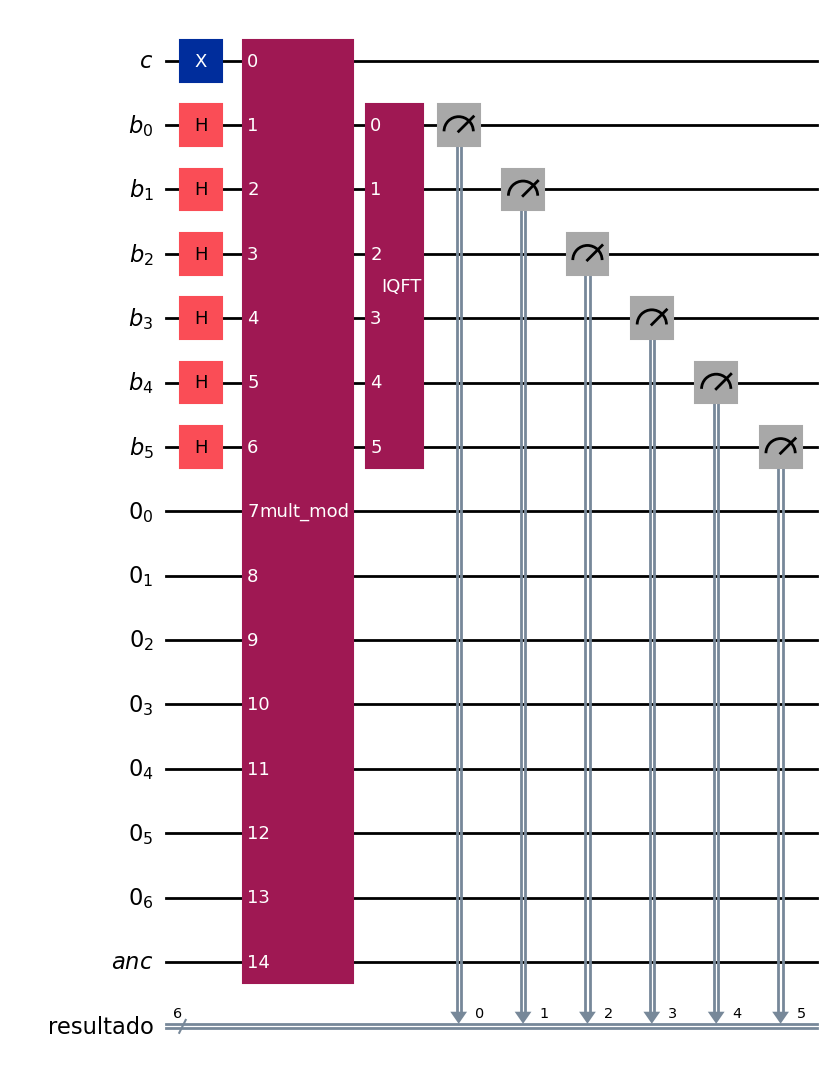

In [28]:
qc.draw("mpl")

In [29]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=2**14)
print(job.result()[0].data.resultado.get_int_counts())

Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(n_bits)):
  if i not in Resultado:
    Resultado[i] = 1

{53: 1982, 38: 14, 10: 431, 32: 2665, 43: 1833, 22: 474, 11: 1919, 0: 2728, 21: 1871, 54: 469, 42: 450, 8: 30, 14: 23, 48: 18, 20: 128, 51: 47, 9: 92, 58: 12, 52: 134, 30: 5, 45: 47, 23: 77, 60: 9, 44: 111, 7: 15, 13: 48, 6: 14, 49: 21, 55: 73, 12: 140, 61: 8, 41: 71, 18: 23, 5: 9, 15: 17, 57: 23, 24: 28, 34: 6, 50: 22, 29: 7, 16: 22, 19: 44, 36: 9, 39: 18, 37: 10, 25: 22, 56: 28, 62: 4, 46: 20, 40: 27, 4: 7, 59: 6, 27: 12, 33: 3, 47: 6, 26: 13, 31: 4, 17: 12, 3: 6, 2: 5, 1: 4, 35: 3, 63: 3, 28: 2}


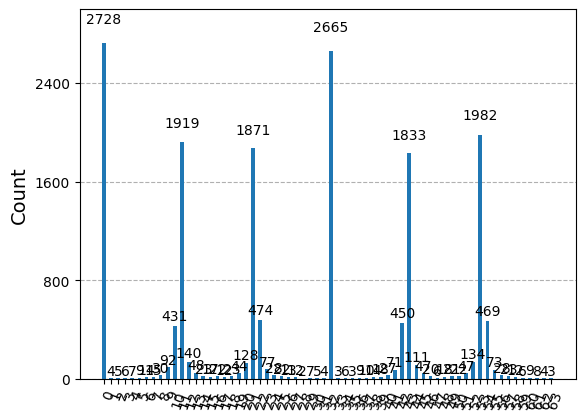

In [30]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)